
# Fuzzy RD Identification

This notebook focuses only on a quasi-experimental **fuzzy regression discontinuity (RD)** design
around the eligibility exit boundary in the synthetic cash-drag panel.

Goal: show an alternative identification path when baseline TWFE diagnostics are weak.


### Variable Names Used In Charts (Reader-Friendly)
- `Months Since Rollover`: lifecycle month after rollover.
- `Any Nudge Exposure`: at least one nudge-channel exposure in a month.
- `Investment Action (Observed)`: observed monthly investment indicator.
- `Cutoff`: eligibility transition between months 6 and 7.


## 1) Setup

In [1]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import get_ipython

RANDOM_SEED = 42
RNG = np.random.default_rng(RANDOM_SEED)

DATA_PATH = 'data/account_month.csv'

# Lightweight controls for bootstrap runtime in notebook mode.
RD_BOOTSTRAP_REPS = 120
IV_BOOTSTRAP_REPS = 120

ip = get_ipython()
if ip is not None:
    ip.run_line_magic('matplotlib', 'inline')

plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='whitegrid')


## 2) Load and Prepare Panel Data

In [2]:

# Only load columns required for RD to keep memory and runtime manageable.
use_cols = [
    'account_id', 'calendar_month', 'months_since_rollover',
    'active_flag', 'eligible_flag', 'invested_flag',
    'treatment_any', 
]

panel = pd.read_csv(DATA_PATH, usecols=use_cols)
panel = panel[panel['active_flag'] == 1].copy()

# Instrument candidate: assignment to any nudge in this month.

print('Rows:', len(panel))
print('Accounts:', panel['account_id'].nunique())
print('Calendar range:', int(panel['calendar_month'].min()), '-', int(panel['calendar_month'].max()))
print('MSR range:', int(panel['months_since_rollover'].min()), '-', int(panel['months_since_rollover'].max()))

panel.head()


Rows: 1525260
Accounts: 50000
Calendar range: 1 - 36
MSR range: 0 - 35


,account_id,calendar_month,months_since_rollover,active_flag,eligible_flag,treatment_any,invested_flag
35,36,1,0,1,0,0,0
44,45,1,0,1,0,0,1
55,56,1,0,1,0,0,0
68,69,1,0,1,0,0,0
103,104,1,0,1,0,0,0



## 3) Fuzzy RD at Eligibility Exit (`msr=6/7`)

We exploit the rule that eligibility is defined for `months_since_rollover in [1,6]`.
At the boundary between month 6 and 7, eligibility shuts off.

- Running variable: `r = months_since_rollover - 6.5`
- Threshold side indicator: `z = 1(msr <= 6)` (eligible side)
- Endogenous treatment: `D = treatment_any`
- Outcome: `Y = invested_flag`

Because treatment does not switch from 1 to 0 deterministically at the threshold,
this is a **fuzzy RD**. We estimate local-linear jumps in `D` and `Y`, then use Wald ratio.


In [3]:

rd = panel.copy()
rd['r'] = rd['months_since_rollover'] - 6.5
rd['z'] = (rd['months_since_rollover'] <= 6).astype(int)

# Keep a broad support for plotting and bandwidth sensitivity.
rd = rd[(rd['months_since_rollover'] >= 1) & (rd['months_since_rollover'] <= 20)].copy()

print('RD rows:', len(rd))
print('RD accounts:', rd['account_id'].nunique())
print('Treatment rate overall:', rd['treatment_any'].mean())
print('Invest rate overall:', rd['invested_flag'].mean())


RD rows: 1000000
RD accounts: 50000
Treatment rate overall: 0.010427
Invest rate overall: 0.037607


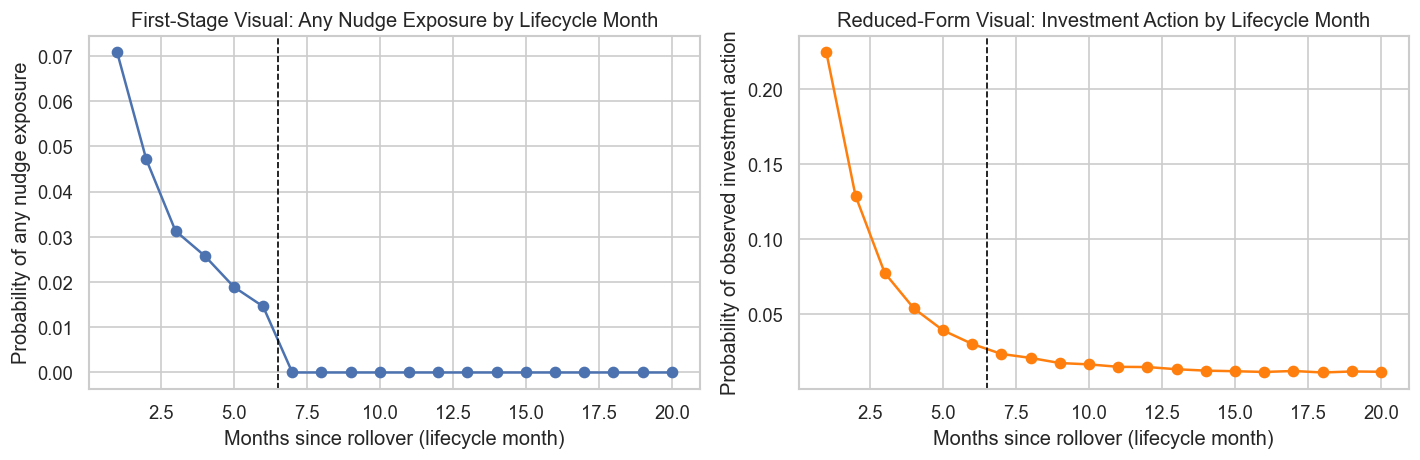

In [4]:

# Binned visualization around the cutoff helps communicate first stage and reduced form intuition.
plot_df = (
    rd.groupby('months_since_rollover')
      .agg(
          treatment_rate=('treatment_any', 'mean'),
          invest_rate=('invested_flag', 'mean'),
          n=('account_id', 'size')
      )
      .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(plot_df['months_since_rollover'], plot_df['treatment_rate'], marker='o')
axes[0].axvline(6.5, color='black', linestyle='--', linewidth=1)
axes[0].set_title('First-Stage Visual: Any Nudge Exposure by Lifecycle Month')
axes[0].set_xlabel('Months since rollover (lifecycle month)')
axes[0].set_ylabel('Probability of any nudge exposure')

axes[1].plot(plot_df['months_since_rollover'], plot_df['invest_rate'], marker='o', color='tab:orange')
axes[1].axvline(6.5, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Reduced-Form Visual: Investment Action by Lifecycle Month')
axes[1].set_xlabel('Months since rollover (lifecycle month)')
axes[1].set_ylabel('Probability of observed investment action')

plt.tight_layout()
plt.show()


In [5]:

def rd_local_linear_jump(data, y_col, bandwidth):
    """
    Estimate local-linear jump at r=0 with interactions:
        y = a + tau*z + b1*r + b2*(z*r) + error
    Returns tau as the discontinuity estimate.
    """
    d = data[data['r'].abs() <= bandwidth].copy()

    X = pd.DataFrame({
        'const': 1.0,
        'z': d['z'].astype(float),
        'r': d['r'].astype(float),
        'z_r': d['z'].astype(float) * d['r'].astype(float),
    })
    y = d[y_col].astype(float)

    m = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': d['account_id']})
    return {
        'coef': float(m.params['z']),
        'se': float(m.bse['z']),
        'p': float(m.pvalues['z']),
        'n_rows': int(len(d)),
        'n_accounts': int(d['account_id'].nunique()),
        'model': m,
        'data': d,
    }


def rd_wald_estimate(data, bandwidth):
    fs = rd_local_linear_jump(data, 'treatment_any', bandwidth)
    rf = rd_local_linear_jump(data, 'invested_flag', bandwidth)

    if abs(fs['coef']) < 1e-8:
        wald = np.nan
    else:
        wald = rf['coef'] / fs['coef']

    return fs, rf, float(wald)


In [6]:

# Main fuzzy RD estimate at a tight local bandwidth.
# Wider bandwidths are reported below as sensitivity checks because lifecycle trend is strong.
RD_BW_MAIN = 2.0

fs_main, rf_main, wald_main = rd_wald_estimate(rd, RD_BW_MAIN)

print(f'RD bandwidth: +/-{RD_BW_MAIN} months around MSR 6.5')
print(f"First stage jump in D: {fs_main['coef']:.4f} (SE {fs_main['se']:.4f}, p={fs_main['p']:.3g})")
print(f"Reduced form jump in Y: {rf_main['coef']:.4f} (SE {rf_main['se']:.4f}, p={rf_main['p']:.3g})")
print(f"Fuzzy RD Local average treatment effect near cutoff: {wald_main:.4f}")
print('Local rows/accounts:', fs_main['n_rows'], fs_main['n_accounts'])


RD bandwidth: +/-2.0 months around MSR 6.5
First stage jump in D: 0.0124 (SE 0.0008, p=1.35e-50)
Reduced form jump in Y: 0.0008 (SE 0.0016, p=0.626)
Fuzzy RD Local average treatment effect near cutoff: 0.0635
Local rows/accounts: 200000 50000


In [7]:

# Bandwidth sensitivity table for transparency.
# With cutoff at MSR=6.5, bw=4 means observations with |MSR-6.5|<=4.
# Because MSR is integer-valued here, that corresponds roughly to MSR in [3, 10].
bandwidths = [2, 3, 4, 5, 6, 8, 10]
rows = []
for bw in bandwidths:
    fs, rf, wald = rd_wald_estimate(rd, bw)
    rows.append({
        'bw': bw,
        'fs_jump': fs['coef'],
        'fs_p': fs['p'],
        'rf_jump': rf['coef'],
        'rf_p': rf['p'],
        'wald_late': wald,
        'n_rows': fs['n_rows'],
        'n_accounts': fs['n_accounts'],
    })

rd_bw_table = pd.DataFrame(rows)
rd_bw_table


/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


,bw,fs_jump,fs_p,rf_jump,rf_p,wald_late,n_rows,n_accounts
0,2,0.012440,1.351723e-50,0.000790,6.261220e-01,0.063505,200000,50000
1,3,0.011373,1.132626e-64,-0.001852,1.425604e-01,-0.162808,300000,50000
2,4,0.011259,4.123752e-78,-0.005613,3.568705e-07,-0.498535,400000,50000
3,5,0.008199,4.469452e-46,-0.017112,2.067488e-62,-2.087084,500000,50000
4,6,0.002945,2.364050e-07,-0.039524,0.000000e+00,-13.422135,600000,50000
5,8,0.002945,2.364026e-07,-0.038853,0.000000e+00,-13.194444,700000,50000
6,10,0.002945,2.364009e-07,-0.038115,0.000000e+00,-12.943706,800000,50000


In [8]:

# Cluster bootstrap CI for Local average treatment effect near cutoff (accounts resampled with replacement).
# This is a practical uncertainty check for the ratio estimate.
local_rd = rd[rd['r'].abs() <= RD_BW_MAIN].copy()
acct_ids = local_rd['account_id'].unique()


def weighted_rd_jump(d, y_col):
    X = pd.DataFrame({
        'const': 1.0,
        'z': d['z'].astype(float),
        'r': d['r'].astype(float),
        'z_r': d['z'].astype(float) * d['r'].astype(float),
    })
    y = d[y_col].astype(float)
    w = d['w'].astype(float)
    m = sm.WLS(y, X, weights=w).fit()
    return float(m.params['z'])

wald_boot = []
for _ in range(RD_BOOTSTRAP_REPS):
    draw = RNG.choice(acct_ids, size=len(acct_ids), replace=True)
    counts = pd.Series(draw).value_counts()

    b = local_rd.copy()
    b['w'] = b['account_id'].map(counts).fillna(0.0)
    b = b[b['w'] > 0].copy()

    fs_b = weighted_rd_jump(b, 'treatment_any')
    rf_b = weighted_rd_jump(b, 'invested_flag')

    if abs(fs_b) > 1e-8:
        wald_boot.append(rf_b / fs_b)

wald_boot = np.asarray(wald_boot)
rd_ci = np.quantile(wald_boot, [0.025, 0.975])

print(f'Fuzzy RD Local average treatment effect near cutoff: {wald_main:.4f}')
print(f'Bootstrap 95% CI: [{rd_ci[0]:.4f}, {rd_ci[1]:.4f}]')
print('Bootstrap reps used:', len(wald_boot))


Fuzzy RD Local average treatment effect near cutoff: 0.0635
Bootstrap 95% CI: [-0.1885, 0.3223]
Bootstrap reps used: 120



## 4) RD Robustness Extensions

These checks help evaluate whether the fuzzy RD signal is stable or sensitive to specification choices.


In [9]:

def rd_jump_with_options(data, y_col, cutoff=6.5, bandwidth=2.0, poly=1, exclude_bins=None):
    """
    Flexible local RD jump estimator for discrete month running variable.
    cutoff=6.5 means left side is MSR<=6, right side is MSR>=7.
    """
    d = data.copy()
    k = int(np.floor(cutoff))
    d['r_tmp'] = d['months_since_rollover'] - cutoff
    d['z_tmp'] = (d['months_since_rollover'] <= k).astype(int)

    local = d[d['r_tmp'].abs() <= bandwidth].copy()
    if exclude_bins is not None:
        local = local[~local['months_since_rollover'].isin(exclude_bins)].copy()

    X = pd.DataFrame({
        'const': 1.0,
        'z': local['z_tmp'].astype(float),
        'r': local['r_tmp'].astype(float),
        'z_r': local['z_tmp'].astype(float) * local['r_tmp'].astype(float),
    })

    if poly == 2:
        X['r2'] = local['r_tmp'].astype(float) ** 2
        X['z_r2'] = local['z_tmp'].astype(float) * (local['r_tmp'].astype(float) ** 2)

    y = local[y_col].astype(float)
    m = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': local['account_id']})

    return {
        'coef': float(m.params['z']),
        'se': float(m.bse['z']),
        'p': float(m.pvalues['z']),
        'n_rows': int(len(local)),
        'n_accounts': int(local['account_id'].nunique()),
    }


In [10]:

# Compare alternative RD specifications.
robust_specs = [
    {'name': 'main_local_linear_bw2', 'cutoff': 6.5, 'bandwidth': 2, 'poly': 1, 'exclude_bins': None},
    {'name': 'local_linear_bw3', 'cutoff': 6.5, 'bandwidth': 3, 'poly': 1, 'exclude_bins': None},
    {'name': 'donut_bw3_drop6_7', 'cutoff': 6.5, 'bandwidth': 3, 'poly': 1, 'exclude_bins': [6, 7]},
    {'name': 'local_quadratic_bw3', 'cutoff': 6.5, 'bandwidth': 3, 'poly': 2, 'exclude_bins': None},
    {'name': 'placebo_cutoff_4_5_bw2', 'cutoff': 4.5, 'bandwidth': 2, 'poly': 1, 'exclude_bins': None},
    {'name': 'placebo_cutoff_8_5_bw2', 'cutoff': 8.5, 'bandwidth': 2, 'poly': 1, 'exclude_bins': None},
]

rows = []
for spec in robust_specs:
    fs = rd_jump_with_options(rd, 'treatment_any', **{k: v for k, v in spec.items() if k != 'name'})
    rf = rd_jump_with_options(rd, 'invested_flag', **{k: v for k, v in spec.items() if k != 'name'})

    wald = np.nan if abs(fs['coef']) < 1e-10 else rf['coef'] / fs['coef']

    rows.append({
        'spec': spec['name'],
        'cutoff': spec['cutoff'],
        'bw': spec['bandwidth'],
        'poly': spec['poly'],
        'first_stage_jump': fs['coef'],
        'first_stage_p': fs['p'],
        'reduced_form_jump': rf['coef'],
        'reduced_form_p': rf['p'],
        'wald_late': wald,
        'n_rows': fs['n_rows'],
    })

rd_robust = pd.DataFrame(rows)
rd_robust


/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


,spec,cutoff,bw,poly,first_stage_jump,first_stage_p,reduced_form_jump,reduced_form_p,wald_late,n_rows
0,main_local_linear_bw2,6.5,2,1,0.012440,1.351723e-50,0.000790,0.626122,0.063505,200000
1,local_linear_bw3,6.5,3,1,0.011373,1.132626e-64,-0.001852,0.142560,-0.162808,300000
2,donut_bw3_drop6_7,6.5,3,1,0.008600,1.275533e-06,-0.008720,0.006817,-1.013953,200000
3,local_quadratic_bw3,6.5,3,2,0.013400,1.596695e-27,0.003167,0.182997,0.236381,300000
4,placebo_cutoff_4_5_bw2,4.5,2,1,0.001970,1.603939e-01,-0.001740,0.418412,-0.883249,200000
5,placebo_cutoff_8_5_bw2,8.5,2,1,0.000000,NaN,0.001650,0.226005,NaN,200000


In [11]:

# Covariate continuity check near the true cutoff.
# If predetermined covariates jump at the threshold, local comparability is weaker.
accounts = pd.read_csv('data/accounts.csv', usecols=['account_id', 'baseline_balance', 'digital_engagement_score', 'advisor_flag'])
rd_cov = rd.merge(accounts, on='account_id', how='left')

cov_rows = []
for cov in ['baseline_balance', 'digital_engagement_score', 'advisor_flag']:
    out = rd_jump_with_options(rd_cov, cov, cutoff=6.5, bandwidth=2, poly=1, exclude_bins=None)
    cov_rows.append({'covariate': cov, 'jump': out['coef'], 'se': out['se'], 'p': out['p'], 'n_rows': out['n_rows']})

rd_covariate_continuity = pd.DataFrame(cov_rows)
rd_covariate_continuity


/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


,covariate,jump,se,p,n_rows
0,baseline_balance,-1.328499e-08,4.784243e-05,0.999778,200000
1,digital_engagement_score,-8.860913e-14,NaN,NaN,200000
2,advisor_flag,-7.617821e-14,5.171631e-10,0.999882,200000



## 5) Cohort-Stratified RD (Rollover Cohorts)

To test whether RD behavior is driven by one rollout segment, we stratify by inferred rollover cohort.
We infer `rollover_month = calendar_month - months_since_rollover` and split into:

- Early: months 1-4
- Mid: months 5-8
- Late: months 9-12

Then we re-estimate fuzzy RD within each cohort using the same cutoff (`msr=6.5`).


In [12]:

rd_strata = rd.copy()
rd_strata['rollover_month'] = (rd_strata['calendar_month'] - rd_strata['months_since_rollover']).astype(int)

rd_strata['rollover_cohort'] = pd.cut(
    rd_strata['rollover_month'],
    bins=[0, 4, 8, 12],
    labels=['Early(1-4)', 'Mid(5-8)', 'Late(9-12)'],
    include_lowest=True,
)

print('Cohort row counts:')
print(rd_strata['rollover_cohort'].value_counts(dropna=False).sort_index())


Cohort row counts:
Early(1-4)    334980
Mid(5-8)      332100
Late(9-12)    332920
Name: rollover_cohort, dtype: int64


In [13]:

# Run the same fuzzy RD inside each cohort and compare bw=2 vs bw=3.
cohort_rows = []
for bw in [2, 3]:
    for cohort in ['Early(1-4)', 'Mid(5-8)', 'Late(9-12)']:
        sub = rd_strata[rd_strata['rollover_cohort'] == cohort].copy()

        fs = rd_jump_with_options(sub, 'treatment_any', cutoff=6.5, bandwidth=bw, poly=1, exclude_bins=None)
        rf = rd_jump_with_options(sub, 'invested_flag', cutoff=6.5, bandwidth=bw, poly=1, exclude_bins=None)

        wald = np.nan if abs(fs['coef']) < 1e-10 else rf['coef'] / fs['coef']

        cohort_rows.append({
            'cohort': cohort,
            'bw': bw,
            'first_stage_jump': fs['coef'],
            'first_stage_p': fs['p'],
            'reduced_form_jump': rf['coef'],
            'reduced_form_p': rf['p'],
            'wald_late': wald,
            'n_rows': fs['n_rows'],
            'n_accounts': fs['n_accounts'],
        })

rd_cohort = pd.DataFrame(cohort_rows)
rd_cohort


/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/jay/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


,cohort,bw,first_stage_jump,first_stage_p,reduced_form_jump,reduced_form_p,wald_late,n_rows,n_accounts
0,Early(1-4),2,0.011702,1.087794e-17,0.003523,0.218913,0.301020,66996,16749
1,Mid(5-8),2,0.013490,2.926504e-20,-0.004818,0.083843,-0.357143,66420,16605
2,Late(9-12),2,0.012135,3.803007e-16,0.003635,0.189766,0.299505,66584,16646
3,Early(1-4),3,0.011006,6.774885e-24,0.000786,0.724596,0.071429,100494,16749
4,Mid(5-8),3,0.011733,4.450991e-23,-0.007603,0.000464,-0.647990,99630,16605
5,Late(9-12),3,0.011384,2.454546e-21,0.001232,0.568004,0.108179,99876,16646


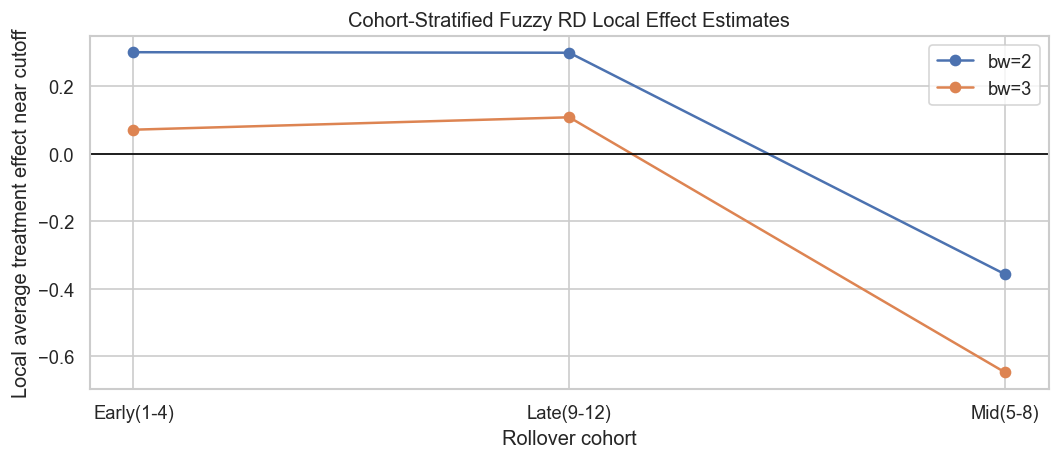

In [14]:

# Simple visual read of cohort-specific Wald estimates by bandwidth.
plot_df = rd_cohort.copy()

fig, ax = plt.subplots(figsize=(9, 4))
for bw, grp in plot_df.groupby('bw'):
    grp = grp.sort_values('cohort')
    ax.plot(grp['cohort'], grp['wald_late'], marker='o', label=f'bw={bw}')

ax.axhline(0, color='black', linewidth=1)
ax.set_title('Cohort-Stratified Fuzzy RD Local Effect Estimates')
ax.set_xlabel('Rollover cohort')
ax.set_ylabel('Local average treatment effect near cutoff')
ax.legend()
plt.tight_layout()
plt.show()


## 6) Local Randomization RD Check

This check treats a very narrow neighborhood around the cutoff as an **as-if randomized** sample.

What we test:
- Are pre-treatment covariates balanced across the left/right side of the cutoff?
- Is the local outcome difference robust under randomization inference?

Note: this is a diagnostic check, not a replacement for the main fuzzy RD estimand.
In this synthetic panel, baseline covariates are account-level and time-invariant, and each account appears on both sides of symmetric windows around the cutoff. So near-perfect covariate balance is expected by construction; the non-trivial signal is the local outcome randomization inference.


In [15]:

# Local randomization balance diagnostics with permutation p-values.
# We avoid parametric assumptions and test whether side-of-cutoff labels could be random.

if 'rd_cov' not in globals():
    accounts = pd.read_csv(
        'data/accounts.csv',
        usecols=['account_id', 'baseline_balance', 'digital_engagement_score', 'advisor_flag']
    )
    rd_cov = rd.merge(accounts, on='account_id', how='left')


def perm_diff_in_means(y, group, reps=300, rng=RNG):
    """
    Two-sided randomization-inference p-value for difference in means.
    Preserves the treated/control counts in each permutation.
    """
    y = np.asarray(y, dtype=float)
    g = np.asarray(group, dtype=int)

    if len(y) == 0 or g.sum() == 0 or g.sum() == len(g):
        return np.nan, np.nan, (np.nan, np.nan)

    obs = y[g == 1].mean() - y[g == 0].mean()

    n = len(g)
    n1 = int(g.sum())
    perm_stats = np.empty(reps)

    for b in range(reps):
        perm_idx = rng.permutation(n)
        perm_g = np.zeros(n, dtype=int)
        perm_g[perm_idx[:n1]] = 1
        perm_stats[b] = y[perm_g == 1].mean() - y[perm_g == 0].mean()

    p_two_sided = (np.sum(np.abs(perm_stats) >= abs(obs)) + 1) / (reps + 1)
    ci_low, ci_high = np.quantile(perm_stats, [0.025, 0.975])
    return obs, p_two_sided, (ci_low, ci_high)


def std_mean_diff(x, g):
    """Standardized mean difference (SMD) for balance diagnostics."""
    x = np.asarray(x, dtype=float)
    g = np.asarray(g, dtype=int)

    x1 = x[g == 1]
    x0 = x[g == 0]
    if len(x1) < 2 or len(x0) < 2:
        return np.nan

    s1 = x1.std(ddof=1)
    s0 = x0.std(ddof=1)
    pooled = np.sqrt((s1 ** 2 + s0 ** 2) / 2)
    if pooled == 0:
        return np.nan
    return (x1.mean() - x0.mean()) / pooled


local_windows = [0.5, 1.5, 2.5]
covariates = ['baseline_balance', 'digital_engagement_score', 'advisor_flag']

balance_rows = []
for h in local_windows:
    d = rd_cov[np.abs(rd_cov['r']) <= h].copy()
    d['right_of_cutoff'] = (d['r'] >= 0).astype(int)

    for cov in covariates:
        y = d[cov].to_numpy()
        g = d['right_of_cutoff'].to_numpy()

        obs, p_perm, _ = perm_diff_in_means(y, g, reps=250, rng=RNG)
        smd = std_mean_diff(y, g)

        balance_rows.append({
            'window_h': h,
            'covariate': cov,
            'mean_left': float(np.mean(y[g == 0])) if (g == 0).sum() > 0 else np.nan,
            'mean_right': float(np.mean(y[g == 1])) if (g == 1).sum() > 0 else np.nan,
            'diff_right_minus_left': obs,
            'smd': smd,
            'perm_p_two_sided': p_perm,
            'n_left': int((g == 0).sum()),
            'n_right': int((g == 1).sum()),
        })

rd_local_balance = pd.DataFrame(balance_rows)
rd_local_balance

,window_h,covariate,mean_left,mean_right,diff_right_minus_left,smd,perm_p_two_sided,n_left,n_right
0,0.5,baseline_balance,40832.238623,40832.238623,0.0,0.0,1.0,50000,50000
1,0.5,digital_engagement_score,0.285607,0.285607,0.0,0.0,1.0,50000,50000
2,0.5,advisor_flag,0.247740,0.247740,0.0,0.0,1.0,50000,50000
3,1.5,baseline_balance,40832.238623,40832.238623,0.0,0.0,1.0,100000,100000
4,1.5,digital_engagement_score,0.285607,0.285607,0.0,0.0,1.0,100000,100000
5,1.5,advisor_flag,0.247740,0.247740,0.0,0.0,1.0,100000,100000
6,2.5,baseline_balance,40832.238623,40832.238623,0.0,0.0,1.0,150000,150000
7,2.5,digital_engagement_score,0.285607,0.285607,0.0,0.0,1.0,150000,150000
8,2.5,advisor_flag,0.247740,0.247740,0.0,0.0,1.0,150000,150000


 window_h msr_range_approx  outcome_diff_right_minus_left  perm_p_two_sided  perm_null_ci_low  perm_null_ci_high  n_rows  n_accounts
      0.5           [6, 7]                      -0.006660          0.002494         -0.002060           0.001861  100000       50000
      1.5           [5, 8]                      -0.012530          0.002494         -0.001292           0.001393  200000       50000
      2.5           [4, 9]                      -0.020513          0.002494         -0.001088           0.001287  300000       50000


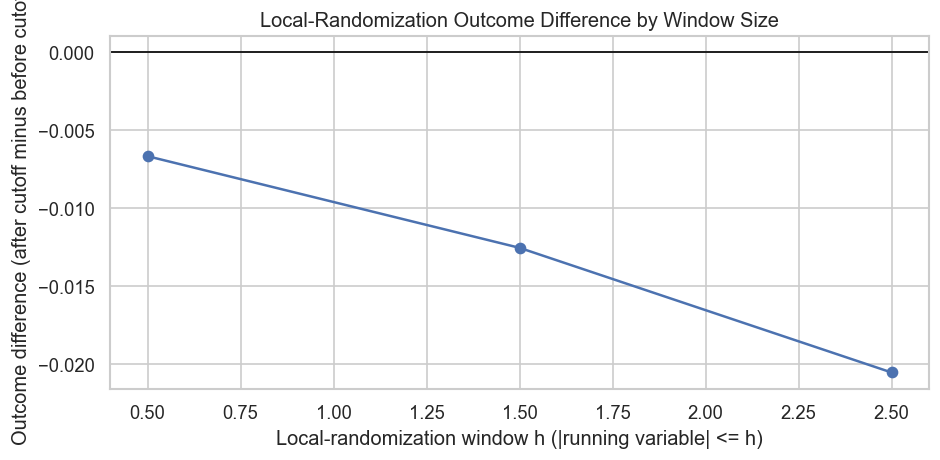

In [16]:
# Local randomization inference for the outcome itself by window.

outcome_rows = []
for h in local_windows:
    d = rd_cov[np.abs(rd_cov['r']) <= h].copy()
    d['right_of_cutoff'] = (d['r'] >= 0).astype(int)

    y = d['invested_flag'].to_numpy()
    g = d['right_of_cutoff'].to_numpy()

    obs, p_perm, ci_perm = perm_diff_in_means(y, g, reps=400, rng=RNG)

    outcome_rows.append({
        'window_h': h,
        'msr_range_approx': f"[{int(np.floor(6.5 - h))}, {int(np.ceil(6.5 + h))}]",
        'outcome_diff_right_minus_left': obs,
        'perm_p_two_sided': p_perm,
        'perm_null_ci_low': ci_perm[0],
        'perm_null_ci_high': ci_perm[1],
        'n_rows': int(len(d)),
        'n_accounts': int(d['account_id'].nunique()),
    })

rd_local_outcome = pd.DataFrame(outcome_rows)
print(rd_local_outcome.to_string(index=False))

# Visual summary of local outcome differences as the window expands.
plot_df = rd_local_outcome.copy()
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(plot_df['window_h'], plot_df['outcome_diff_right_minus_left'], marker='o')
ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('Local-randomization window h (|running variable| <= h)')
ax.set_ylabel('Outcome difference (after cutoff minus before cutoff)')
ax.set_title('Local-Randomization Outcome Difference by Window Size')
plt.tight_layout()
plt.show()


## 7) RD Interpretation Checklist

- The fuzzy RD estimate is a **local LATE** around the eligibility-exit threshold (`MSR ≈ 6/7`).
- Stability across bandwidth/specification is important; large drift suggests sensitivity to lifecycle trend or functional form.
- Placebo cutoffs should not show a treatment-like pattern if the design is clean.
- Covariate continuity near cutoff supports local comparability.

Use this notebook as a diagnostics-first causal argument, not as one single definitive number.


In [17]:

rd_summary = pd.DataFrame([
    {
        'method': f'Fuzzy RD Wald (bw={int(RD_BW_MAIN)})',
        'estimate': wald_main,
        'ci_low': rd_ci[0],
        'ci_high': rd_ci[1],
        'note': 'Main local-linear specification at cutoff 6.5',
    },
    {
        'method': 'Bandwidth table median Wald',
        'estimate': float(rd_bw_table['wald_late'].median()),
        'ci_low': np.nan,
        'ci_high': np.nan,
        'note': 'Quick stability summary across bandwidths',
    },
])

rd_summary


,method,estimate,ci_low,ci_high,note
0,Fuzzy RD Wald (bw=2),0.063505,-0.18851,0.322332,Main local-linear specification at cutoff 6.5
1,Bandwidth table median Wald,-2.087084,NaN,NaN,Quick stability summary across bandwidths
